In [152]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import lstsq
from matplotlib.cm import get_cmap
from matplotlib.colors import LinearSegmentedColormap
from scipy.ndimage.filters import gaussian_filter
from scipy.spatial import Voronoi
from scipy.ndimage.morphology import binary_dilation, binary_erosion, binary_opening, binary_closing
from itertools import permutations
from sklearn.decomposition import NMF

import py4DSTEM
from py4DSTEM.file.datastructure import PointListArray
from py4DSTEM.process.utils import get_maxima_2D, add_to_2D_array_from_floats, get_voronoi_vertices
from py4DSTEM.process.classification import get_braggpeak_labels_by_scan_position, get_initial_classes

In [4]:
fp = "/home/ben/Data/20190128_ClassificationData/EASY_binDiffraction4.h5"
#fp = "/Users/Ben/Desktop/EASY_binDiffraction4_no_datacube.h5"
browser = py4DSTEM.file.readwrite.FileBrowser(fp)
ave_im = browser.get_dataobject('average_image').data2D
deconvolution = browser.get_dataobject('deconvolution').data2D
braggpeaks = browser.get_dataobject('Bragg_peaks')
browser.close()

Q_Nx, Q_Ny = deconvolution.shape
R_Nx,R_Ny = ave_im.shape

### The data to classify

Left: a virtual BF image of some polycrystalline Au nanoparticles

Right: A Bragg vector map, in which a spatially averaged distribution of the Bragg directions in diffraction space has been calculated and plotted.  In generating the plot, the Bragg directions are first determined by identifing reflections of the CBED disk in diffraction space, by identifying the maxima of a correlation function between the vacuum probe and each diffraction pattern.  Next, translation of the diffraction patterns with the scanning of the beam is fit to a linear or, for large scan areas, higher order polynomial function.  These shifts are corrected for. Finally, the intensities of the cross correlation maxima are summed, by position in diffraction space, yielding the object plotted, $\mathcal{B}(\mathbf{q})$.  We refer to this object as a Map of the Bragg vectOr directions in the diffraction Plane (MBOP).  Mathematically, the MBOP is given by $\mathcal{B}(\mathbf{q}) = \int I_{x,y,i} \delta(\mathbf{q}-\mathbf{q}_{x,y,i})$, where $\mathbf{q}_{x,y,i}$ is the $i$'th Bragg peak detected in the diffraction pattern collected at scan position $(x,y)$, and $\mathbf{I}_{x,y,i}$ is that peak's cross correlation intensity.

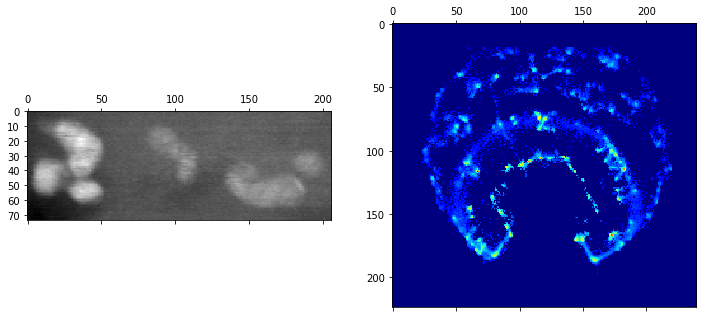

In [5]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,6))
ax1.matshow(ave_im)
ax2.matshow(deconvolution**0.2,cmap='jet')
plt.show()

#### Get bragg peaks sets at each scan position

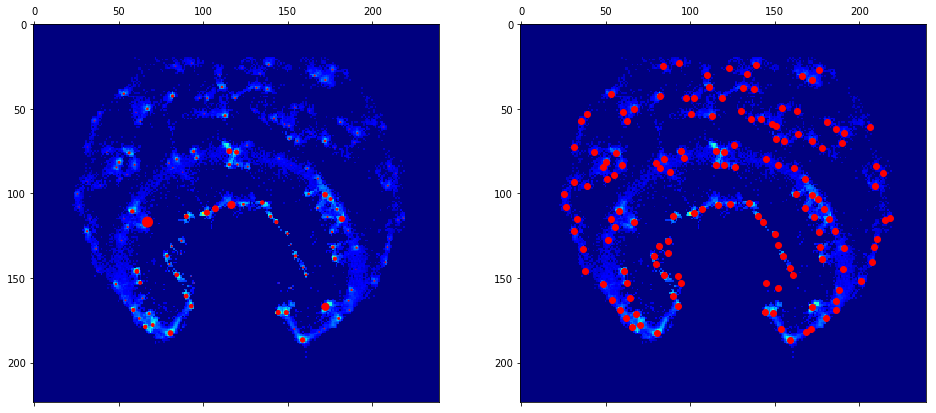

In [6]:
# Get deconvolution maxima

sigma = 1
edgeBoundary = 0
minSpacing = 0
minRelativeIntensity = 0.0005
relativeToPeak = 0
maxNumPeaks = 0
subpixel = True

power = 0.25
scale = 100

maxima_x, maxima_y, maxima_int = get_maxima_2D(deconvolution, sigma=sigma, edgeBoundary=edgeBoundary,
                                               minSpacing=minSpacing, minRelativeIntensity=minRelativeIntensity,
                                               relativeToPeak=relativeToPeak, maxNumPeaks=maxNumPeaks,
                                               subpixel=subpixel)
N = len(maxima_x)

# Show
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(16,8))
ax1.matshow(deconvolution**power,cmap='jet')
ax1.scatter(maxima_y,maxima_x,color='r',
            s=scale*maxima_int/np.max(maxima_int))
ax2.matshow(deconvolution**power,cmap='jet')
ax2.scatter(maxima_y,maxima_x,color='r')
plt.show()

In [7]:
# Get the sets of Bragg peaks present at each scan position

braggpeak_labels = get_braggpeak_labels_by_scan_position(braggpeaks,maxima_x,maxima_y)

#### Show Voronoi diagram

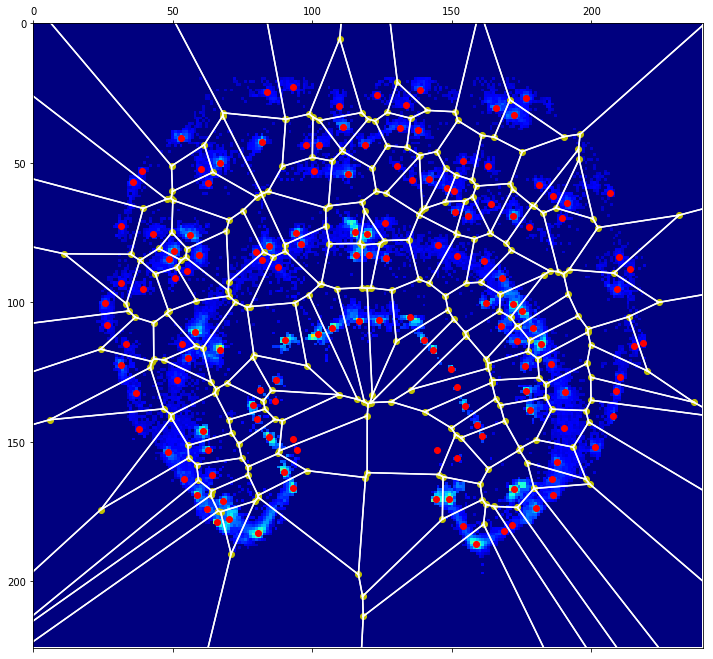

In [8]:
# Make a Voronoi diagram
points = np.vstack((maxima_x,maxima_y)).T
voronoi = Voronoi(points)

# Get vertices
vertices = get_voronoi_vertices(voronoi, Q_Nx, Q_Ny)

# Show
fig,ax=plt.subplots(figsize=(12,12))
ax.matshow(deconvolution**0.25,cmap='jet')
ax.scatter(voronoi.points[:,1],voronoi.points[:,0],color='r')
ax.scatter(voronoi.vertices[:,1],voronoi.vertices[:,0],color='y')
for region in range(len(vertices)):
    vertices_curr = vertices[region]
    for i in range(len(vertices_curr)):
        x0,y0 = vertices_curr[i,:]
        x1,y1 = vertices_curr[(i+1)%len(vertices_curr),:]
        ax.plot((y0,y1),(x0,x1),'w')        
ax.set_xlim([0,deconvolution.shape[1]])
ax.set_ylim([0,deconvolution.shape[0]])
plt.gca().invert_yaxis()
plt.show()

Our classification scheme begins with an MBOP.  First, we find all the local maxima, assigning an integer $i\in[1,N]$ to each.  Next, we label each detected diffraction pattern with one of these integers, according to which MBOP maximum is closest.  Finally, we assign to each diffraction pattern a set of integers describing the Bragg peaks detected therein.

#### Get initial classes

The classes $\mathbf{c}$ in our classification scheme may be thought of as length $N$ vectors, with the $i$'th component $c_i \in [0,1]$ describing the likelihood of bragg peak $i$ occuring in a diffraction pattern of this class.  For the moment, we do not consider the classes relationships to real space.

In the initial classes, the $c_i$ are boolean: each bragg peak either is, or is not, a member of each class.  The first of these classes is generated by calculating $P(i,j,k)$, the joint probability that the set ${i,j,k}$ of three Bragg peak labels will co-occur in any given diffraction pattern.  The set that maximizes this probability, $S = \argmax_{\{i,j,k\}}P(i,j,k)$, is set as the initial state of the class.  Then, we find the next most likely Bragg peak to be co-located in a diffraction pattern with the three peaks in $S$, i.e. we find $l = \argmax_x P(x | i,j,k)$.  If $P(l | i,j,k)$ is greater than some threshold, we add $l$ to the set of Bragg peaks $S$, and then repeat, i.e. next finding $m = \argmax_x P(x | i,j,k,l)$ and $P(m | i,j,k,l)$, until the threshold is no longer satisfied.  The set of Bragg peak labels thus found are then considered members of the class, and we set $c_i = 1$ for all $i \in S$.

This describes the first of the initial classes, call it $S_1$.  To obtain $S_2$, we recalculate $P(i,j,k)$, this time setting all values containing any of the peaks in $S_1$ to zero, i.e. we find $P(i,j,k)\prod_{i \in S_1)(1-\delta(i))$.  We grow $S_2$ following the same procedure described for $S_1$, i.e. by iteratively calculating $i = \argmax_x P(x | S)$ and $P(i | S)$ and adding bragg peak labels when $P(i | S) > \text{some threshold}$. We continue seeding new classes using $P(i,j,k)\prod_{i_1 \in S_1)\prod_{i_2 \in S_2)...(1-\delta(i_1))(1-\delta(i_2))...$, until one of several termination conditions are met: either a class is repeated, a maximum number of classes in surpassed, or the fraction of remaining Bragg peaks which have not been used in any class falls below a threshhold.

TODO: classes *should not* be repeated.  They are, and I'm at present using this rule rather than understand what's breaking.  Need to figure out where error is.

In [9]:
thresh = 0.3
BP_fraction_thresh = 0.1
max_iterations = 200

BP_sets = get_initial_classes(braggpeak_labels, N=N, thresh=thresh, BP_fraction_thresh=BP_fraction_thresh,
                                                                    max_iterations=max_iterations)

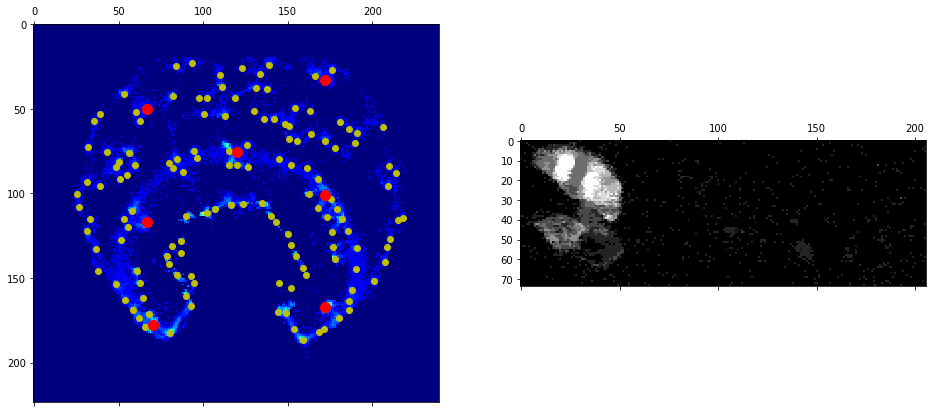

In [10]:
index = 0

class_BP_set = BP_sets[index]
class_map = np.zeros((R_Nx,R_Ny))
for Rx in range(R_Nx):
    for Ry in range(R_Ny):
        s = braggpeak_labels[Rx][Ry]
        class_map[Rx,Ry] = len(s.intersection(class_BP_set))/len(class_BP_set)


fig,(ax1,ax2) = plt.subplots(1,2,figsize=(16,8))
ax1.matshow(deconvolution**power,cmap='jet')
ax1.scatter(maxima_y,maxima_x,color='y')
for i in class_BP_set:
    ax1.scatter(maxima_y[i],maxima_x[i],color='r',s=100)
ax1.grid(False)
ax2.matshow(class_map)
ax2.grid(False)
plt.show()

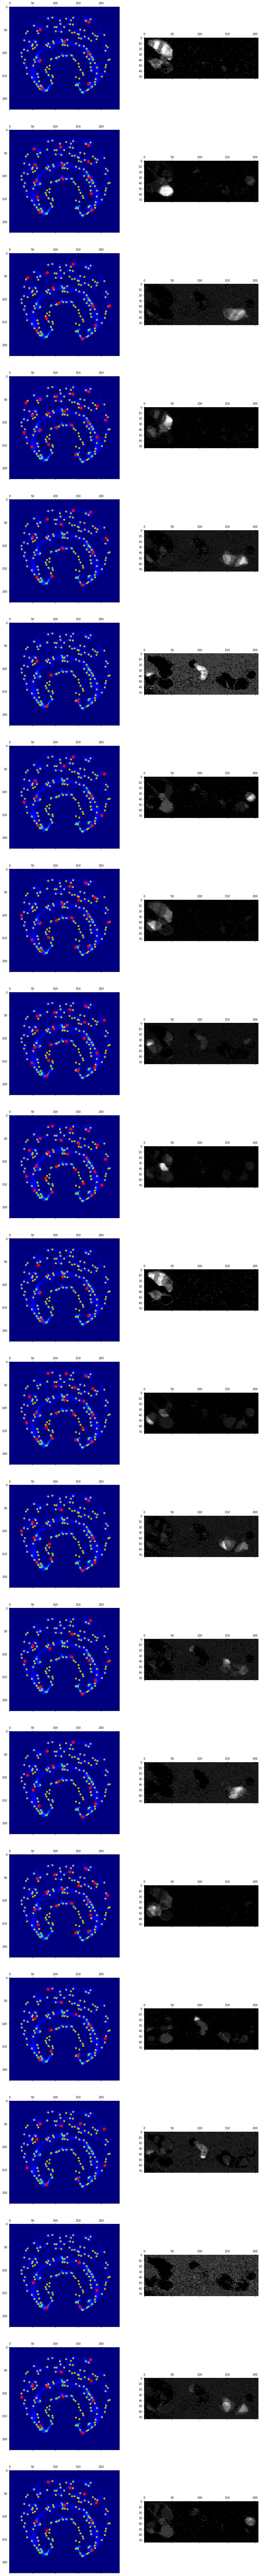

In [11]:
sizescale = 100

fig,axs = plt.subplots(len(BP_sets),2,figsize=(16,8*len(BP_sets)))

for index in range(len(BP_sets)):
    
    class_BP_set = BP_sets[index]
    class_map = np.zeros((R_Nx,R_Ny))
    for Rx in range(R_Nx):
        for Ry in range(R_Ny):
            s = braggpeak_labels[Rx][Ry]
            class_map[Rx,Ry] = len(s.intersection(class_BP_set))/len(class_BP_set)

    ax1,ax2 = axs[index,:]
    ax1.matshow(deconvolution**power,cmap='jet')
    ax1.scatter(maxima_y,maxima_x,color='y')
    for i in class_BP_set:
        ax1.scatter(maxima_y[i],maxima_x[i],color='r',s=sizescale)
    ax1.grid(False)
    ax2.matshow(class_map)
    ax2.grid(False)

plt.show()

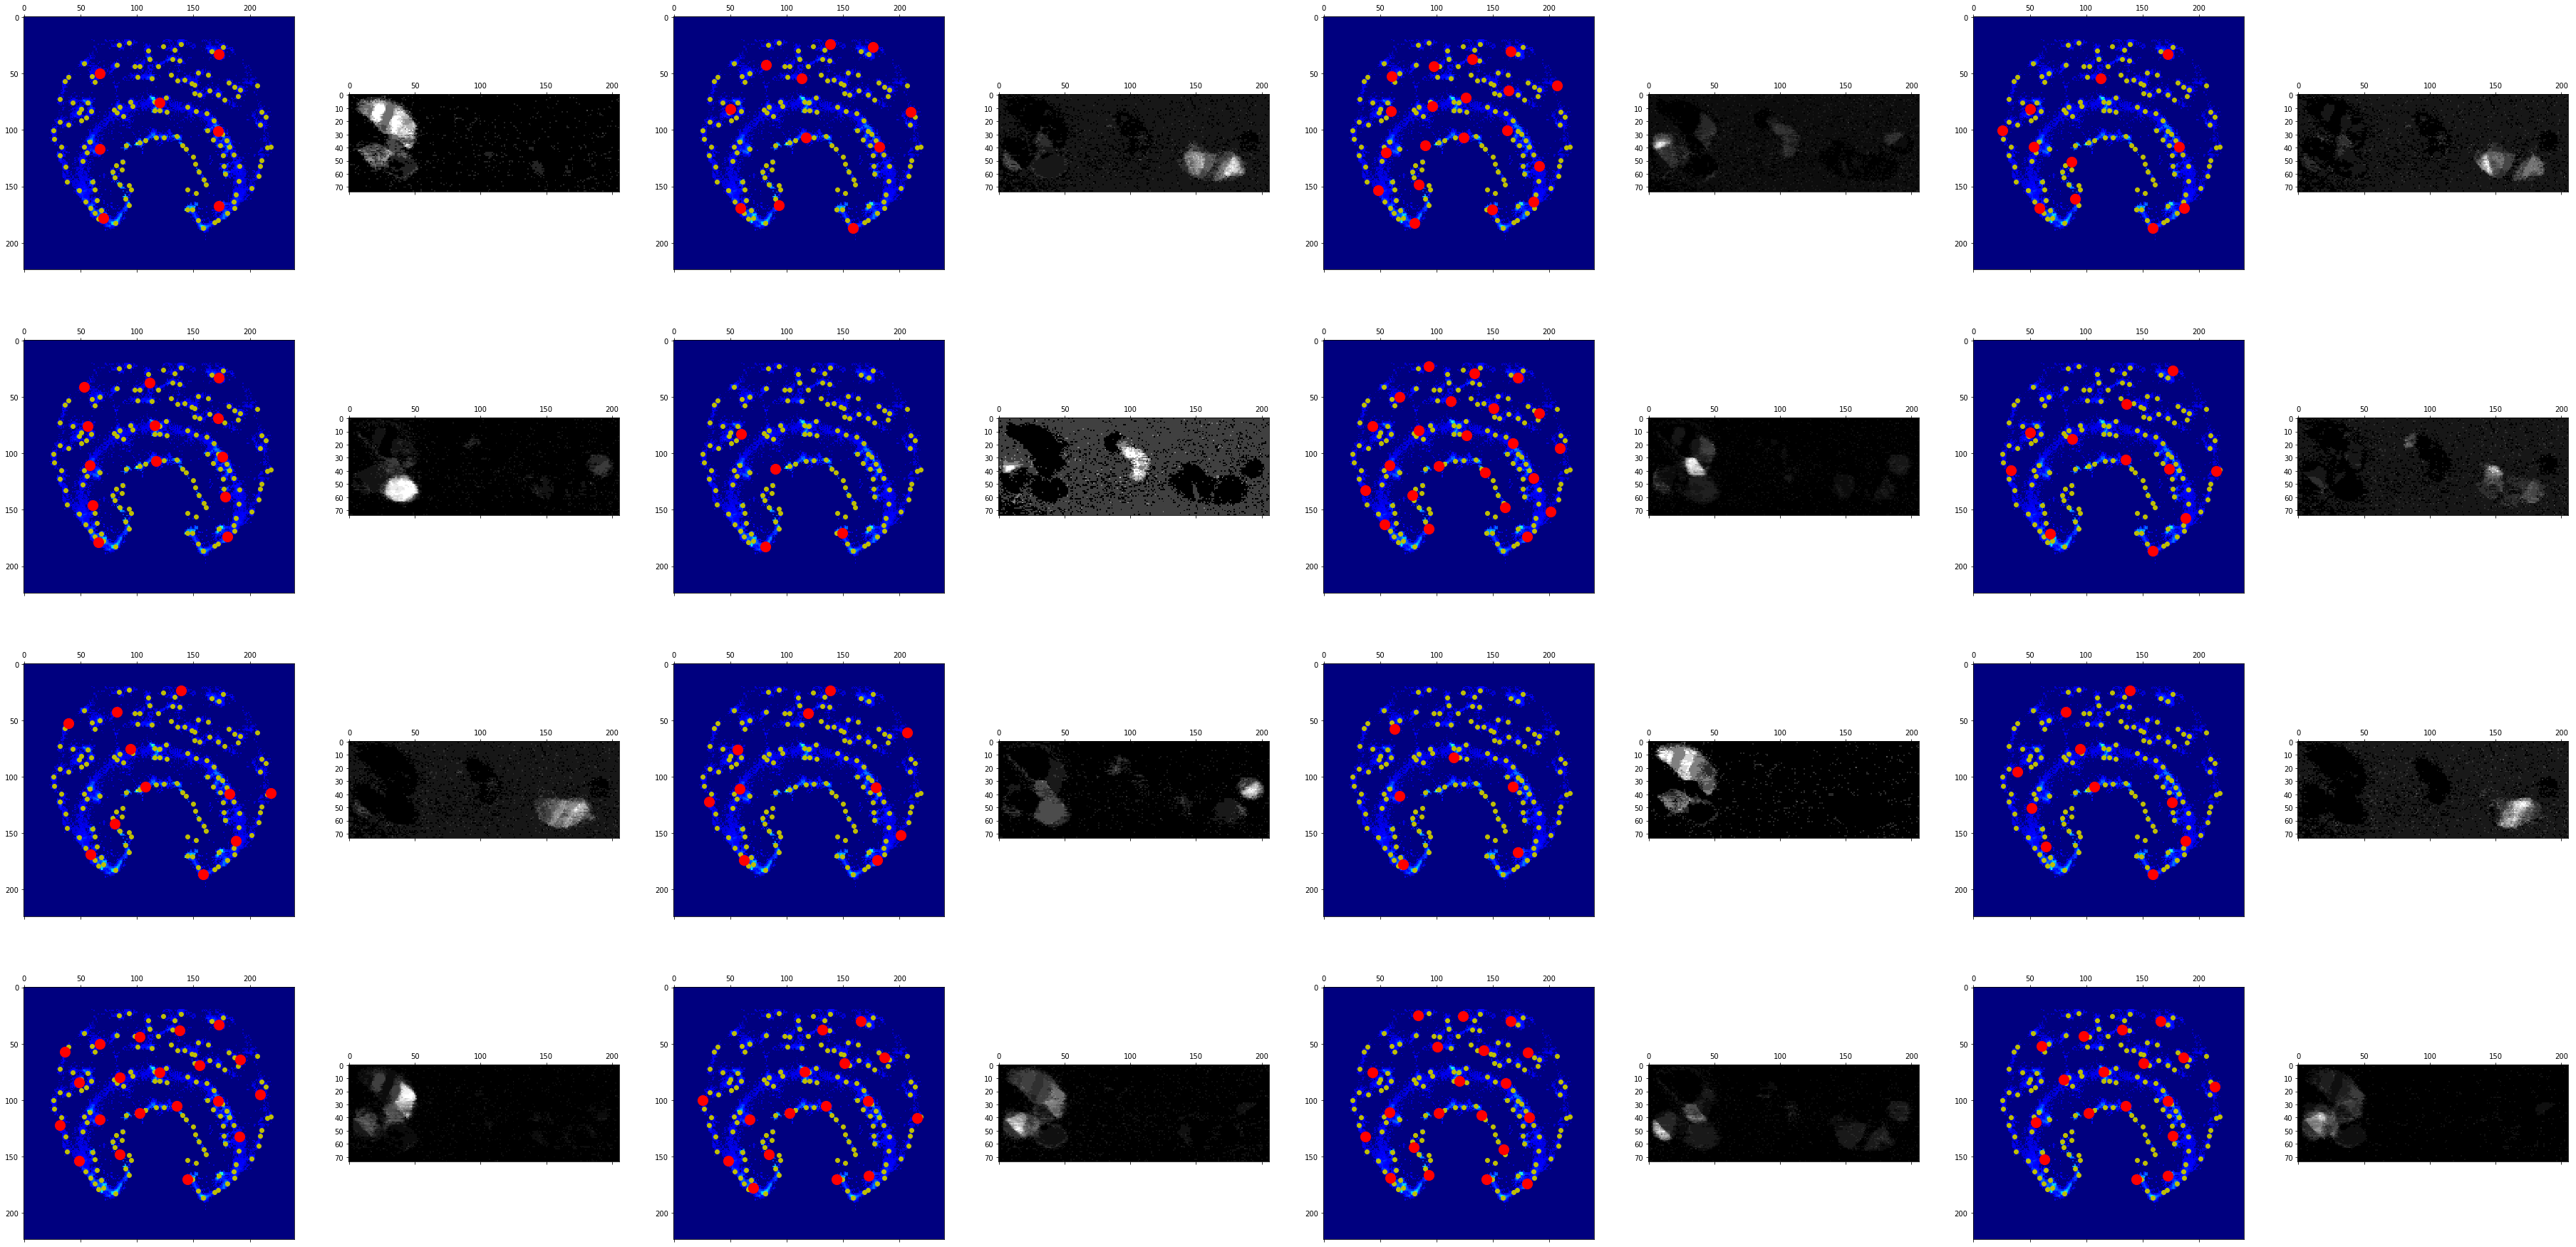

In [12]:
sizescale = 200

fig,axs = plt.subplots(4,8,figsize=(16*4,8*4))

for index in range(len(BP_sets)):
    if index < 16:
        ax1 = axs[index%4,2*(index//4)]
        ax2 = axs[index%4,2*(index//4)+1]
    
        class_BP_set = BP_sets[index]
        class_map = np.zeros((R_Nx,R_Ny))
        for Rx in range(R_Nx):
            for Ry in range(R_Ny):
                s = braggpeak_labels[Rx][Ry]
                class_map[Rx,Ry] = len(s.intersection(class_BP_set))/len(class_BP_set)

        ax1.matshow(deconvolution**power,cmap='jet')
        ax1.scatter(maxima_y,maxima_x,color='y')
        for i in class_BP_set:
            ax1.scatter(maxima_y[i],maxima_x[i],color='r',s=sizescale)
        ax1.grid(False)
        ax2.matshow(class_map)
        ax2.grid(False)

plt.show()

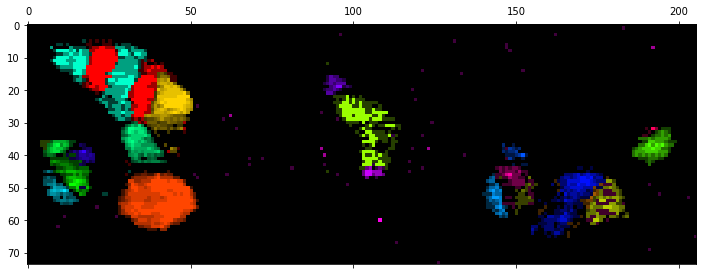

In [13]:
# Plot overlay

thresh = 0.6
cmap_base = get_cmap('hsv')

fig,ax = plt.subplots(figsize=(12,12))
ax.matshow(np.zeros((R_Nx,R_Ny)))

for index in range(len(BP_sets)):
    BP_set = BP_sets[index]
    class_map = np.zeros((R_Nx,R_Ny))
    for Rx in range(R_Nx):
        for Ry in range(R_Ny):
            s = braggpeak_labels[Rx][Ry]
            class_map[Rx,Ry] = len(s.intersection(BP_set))/len(BP_set)
    ma = np.ma.array(class_map, mask = class_map<thresh)

    #colors = [(0,0,0,1),cmap_base(index/len(BP_sets))]
    c1 = cmap_base(index/len(BP_sets))
    c0 = (c1[0]/4.,c1[1]/4.,c1[2]/4.,1)
    colors = [c0,c1]
    cm = LinearSegmentedColormap.from_list('cmap', colors, N=100)
    ax.matshow(ma,cmap=cm)

plt.show()

#### Non-negative matrix factorization

In [293]:
bools = True   # X matrix includes BP intensities, or just if a BP is present or not

# Construct relevant matrices: X = WH
# X is the data matrix
# W is the feature matrix
# H is the weighting matrix

# Lenghts
N_feat = N
N_meas = R_Nx*R_Ny
N_c = len(BP_sets)

# X - shape (#BPs, #classes). Column i gives the Bragg peaks intensities at scan position i
X = np.zeros((N_feat,N_meas))
for Rx in range(R_Nx):
    for Ry in range(R_Ny):
        R = Rx*R_Ny + Ry
        s = braggpeak_labels[Rx][Ry]
        pointlist = braggpeaks.get_pointlist(Rx,Ry)
        for i in s:
            if bools is True:
                X[i,R] = 1
            else:
                qx,qy = maxima_x[i],maxima_y[i]
                ind = np.argmin(np.hypot(pointlist.data['qx']-qx,pointlist.data['qy']-qy))
                X[i,R] = pointlist.data['intensity'][ind]
                   
# W - shape (#BPs, #classes). Each column is a class, containing the weightings for the BPs in the class
W = np.zeros((N_feat, N_c))
for i in range(N_c):
    BP_set = BP_sets[i]
    for j in BP_set:
        W[j,i] = 1

# H - shape (#classes, #scan positions). Column i specifies the weights of each class contributing to scan position i
H = lstsq(W,X,rcond=None)[0]
H = np.where(H<0,0,H)
# H = np.zeros((N_c,N_meas))
# for i in range(N_c):
#     BP_set = BP_sets[index]
#     class_map = np.zeros((R_Nx,R_Ny))
#     for Rx in range(R_Nx):
#         for Ry in range(R_Ny):
#             s = braggpeak_labels[Rx][Ry]
#             class_map[Rx,Ry] = len(s.intersection(BP_set))/len(BP_set)
#     H[i,:] = class_map.ravel()
# # Normalize H such that for a scan position with n BPs, the corresponding column vector in H sums to n
# for i in range(N_meas):
#     n = np.sum(X[:,i])
#     if n>0:
#         H[:,i] = H[:,i]/np.sum(X[:,i])

In [294]:
max_iter = 3

nmf = NMF(n_components=N_c, init='custom', max_iter=max_iter)

In [295]:
W = nmf.fit_transform(X, W=W, H=H)
H = nmf.components_

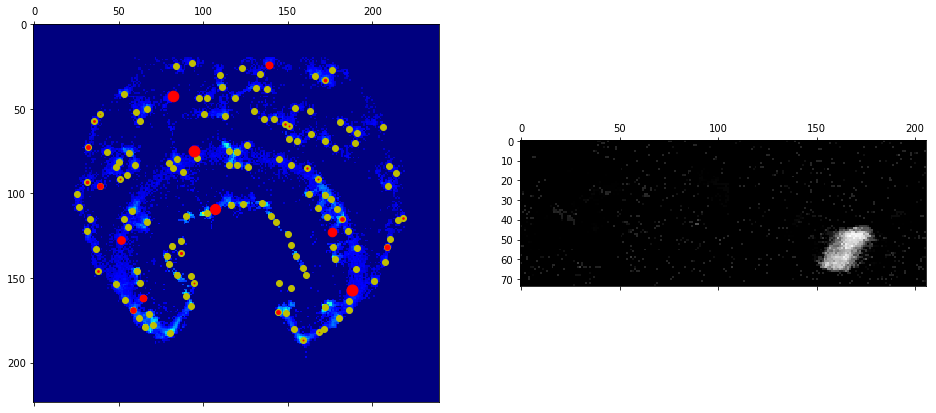

In [296]:
# Show classes

class_index = 14
sizescale = 100

BP_vals = W[:,class_index]
R_vals = H[class_index,:]

class_map = R_vals.reshape((R_Nx,R_Ny))
# class_map = np.zeros((R_Nx,R_Ny))
# for Rx in range(R_Nx):
#     for Ry in range(R_Ny):
#         class_map[Rx,Ry] = R_vals[Ry*R_Nx+Rx]

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(16,8))
ax1.matshow(deconvolution**power,cmap='jet')
ax1.scatter(maxima_y,maxima_x,color='y')
for i in range(N):
    ax1.scatter(maxima_y[i],maxima_x[i],color='r',s=sizescale*BP_vals[i])
ax1.grid(False)
ax2.matshow(class_map)
ax2.grid(False)
plt.show()

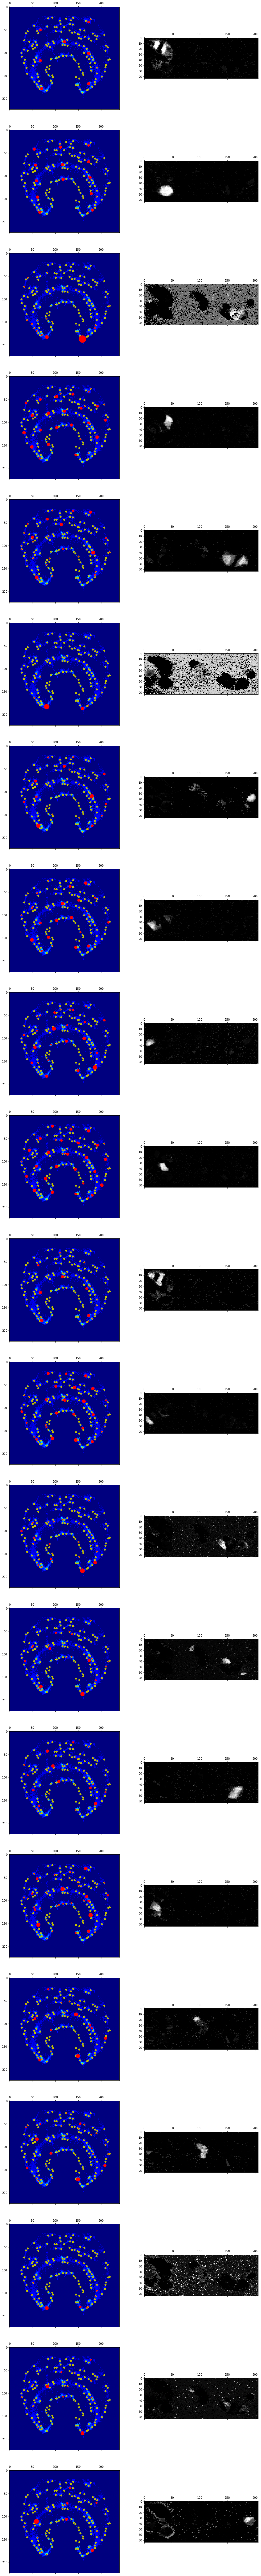

In [255]:
sizescale = 100

fig,axs = plt.subplots(len(BP_sets),2,figsize=(16,8*len(BP_sets)))

for index in range(len(BP_sets)):
    
    BP_vals = W[:,index]
    R_vals = H[index,:]
    class_map = R_vals.reshape((R_Nx,R_Ny))
    
    ax1,ax2 = axs[index,:]
    ax1.matshow(deconvolution**power,cmap='jet')
    ax1.scatter(maxima_y,maxima_x,color='y')
    for i in range(N):
        ax1.scatter(maxima_y[i],maxima_x[i],color='r',s=sizescale*BP_vals[i])
    ax1.grid(False)
    ax2.matshow(class_map)
    ax2.grid(False)

plt.show()

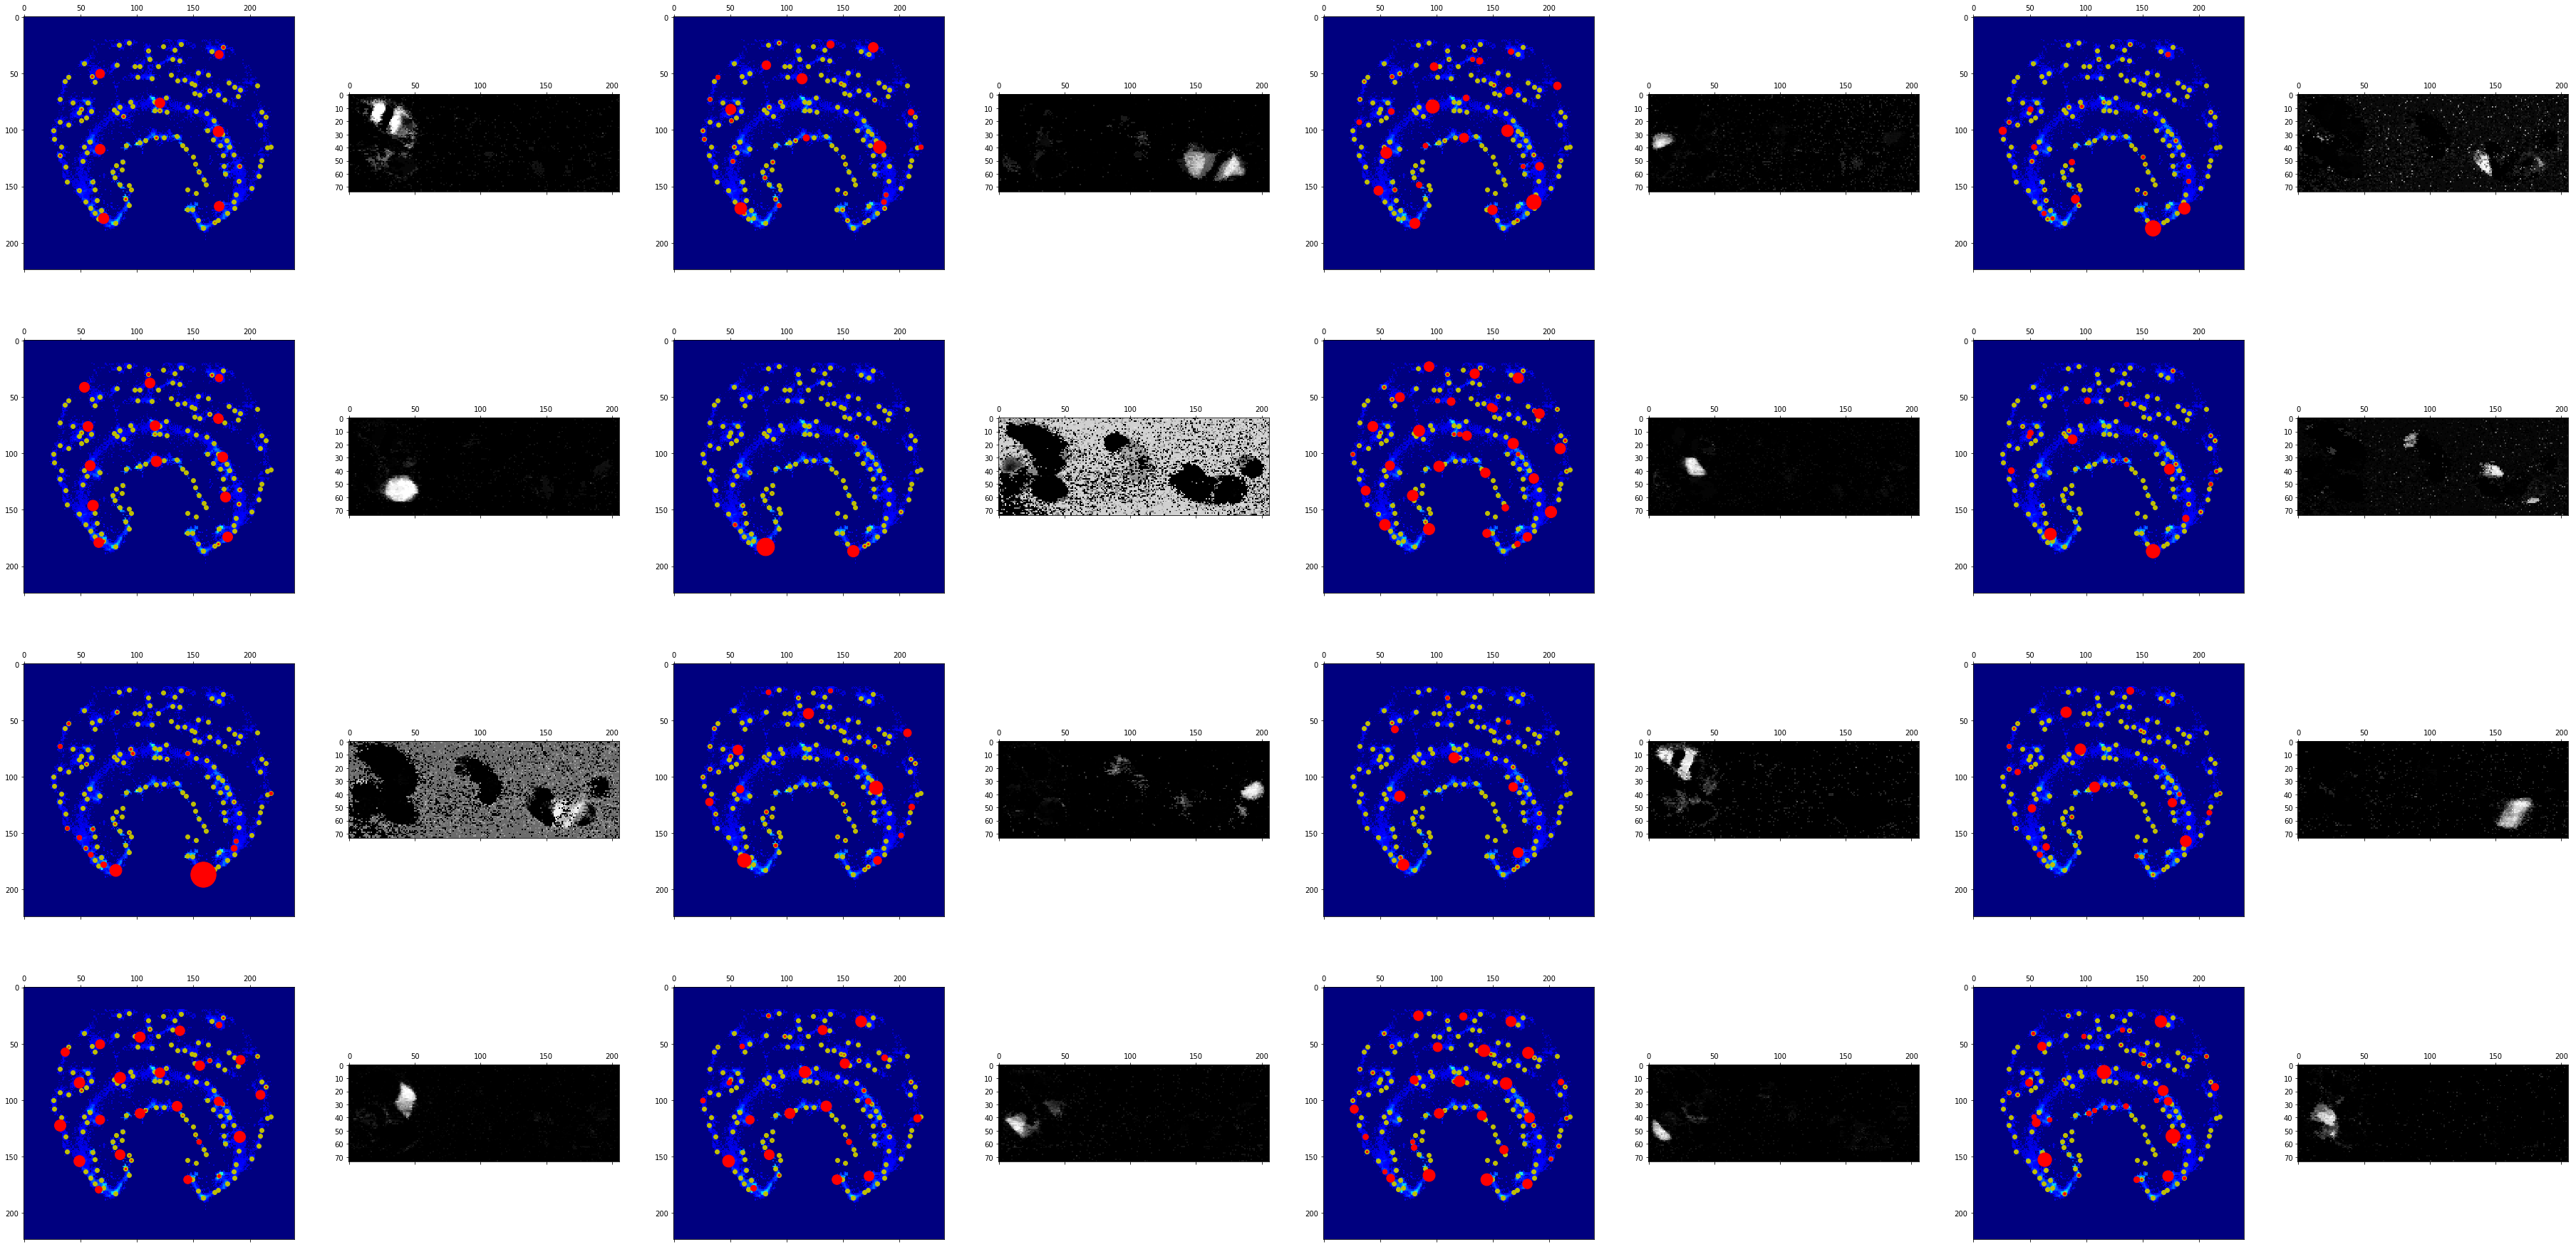

In [256]:
sizescale=200

fig,axs = plt.subplots(4,8,figsize=(16*4,8*4))

for index in range(len(BP_sets)):
    if index < 16:
        ax1 = axs[index%4,2*(index//4)]
        ax2 = axs[index%4,2*(index//4)+1]
    
        BP_vals = W[:,index]
        R_vals = H[index,:]
        class_map = R_vals.reshape((R_Nx,R_Ny))

        ax1.matshow(deconvolution**power,cmap='jet')
        ax1.scatter(maxima_y,maxima_x,color='y')
        for i in range(N):
            ax1.scatter(maxima_y[i],maxima_x[i],color='r',s=sizescale*BP_vals[i])
        ax1.grid(False)
        ax2.matshow(class_map)
        ax2.grid(False)

plt.show()

/home/ben/Software/anaconda3/lib/python3.7/site-packages/matplotlib/image.py:405: UserWarning: Warning: converting a masked element to nan.
  dv = (np.float64(self.norm.vmax) -
/home/ben/Software/anaconda3/lib/python3.7/site-packages/matplotlib/image.py:406: UserWarning: Warning: converting a masked element to nan.
  np.float64(self.norm.vmin))
/home/ben/Software/anaconda3/lib/python3.7/site-packages/matplotlib/image.py:413: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/ben/Software/anaconda3/lib/python3.7/site-packages/matplotlib/image.py:418: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/ben/Software/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:916: UserWarning: Warning: converting a masked element to nan.
  dtype = np.min_scalar_type(value)
/home/ben/Software/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:715: UserWarning: Warning: converting a masked element to nan.
 

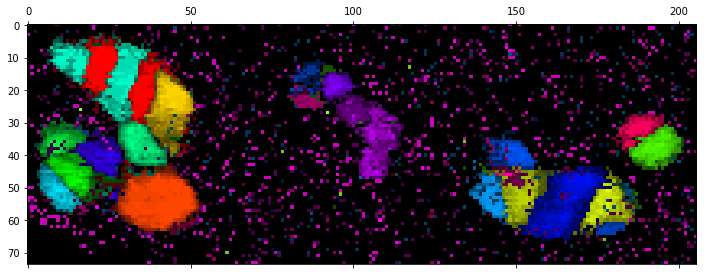

In [257]:
# Plot overlay

thresh = 0.3
cmap_base = get_cmap('hsv')

fig,ax = plt.subplots(figsize=(12,12))
ax.matshow(np.zeros((R_Nx,R_Ny)))

for index in range(len(BP_sets)):
    R_vals = H[index,:]
    class_map = R_vals.reshape((R_Nx,R_Ny))
    ma = np.ma.array(class_map, mask = class_map<thresh)

    #colors = [(0,0,0,1),cmap_base(index/len(BP_sets))]
    c1 = cmap_base(index/len(BP_sets))
    c0 = (c1[0]/4.,c1[1]/4.,c1[2]/4.,1)
    colors = [c0,c1]
    cm = LinearSegmentedColormap.from_list('cmap', colors, N=100)
    ax.matshow(ma,cmap=cm)

plt.show()

### Split classes

In [297]:
sigma = 2
thresholdSplit = 0.25
expandMask = 1

W_split = np.zeros((N_feat,1))
H_split = np.zeros((1,N_meas))
for i in range(N_c):
    # Get the class in real space
    class_image = np.reshape(H[i,:],(R_Nx,R_Ny))
    
    # Turn into a binary mask
    class_image = gaussian_filter(class_image,sigma)
    mask = class_image > (np.max(class_image)*thresholdSplit)
    mask = binary_opening(mask, iterations=1)
    mask = binary_closing(mask, iterations=1)
    mask = binary_dilation(mask, iterations=expandMask)
    
    # Get connected regions
    labels, nlabels = label(mask,background=0,return_num=True,connectivity=2)
    
    # Add each region to the new W and H matrices
    for j in range(nlabels):
        mask = (labels == (j+1))
        mask = binary_erosion(mask, iterations=expandMask)

        # Leave the bragg peak weightings the same
        W_split = np.hstack((W_split,W[:,i,np.newaxis]))
        
        # Use the existing real space pixel weightings
        H_vals = np.zeros(N_meas)
        H_vals[mask.ravel()] = H[i,:][mask.ravel()]
        H_split = np.vstack((H_split,H_vals[np.newaxis,:]))
        
W_split = W_split[:,1:]
H_split = H_split[1:,:]
N_c = W_split.shape[1]

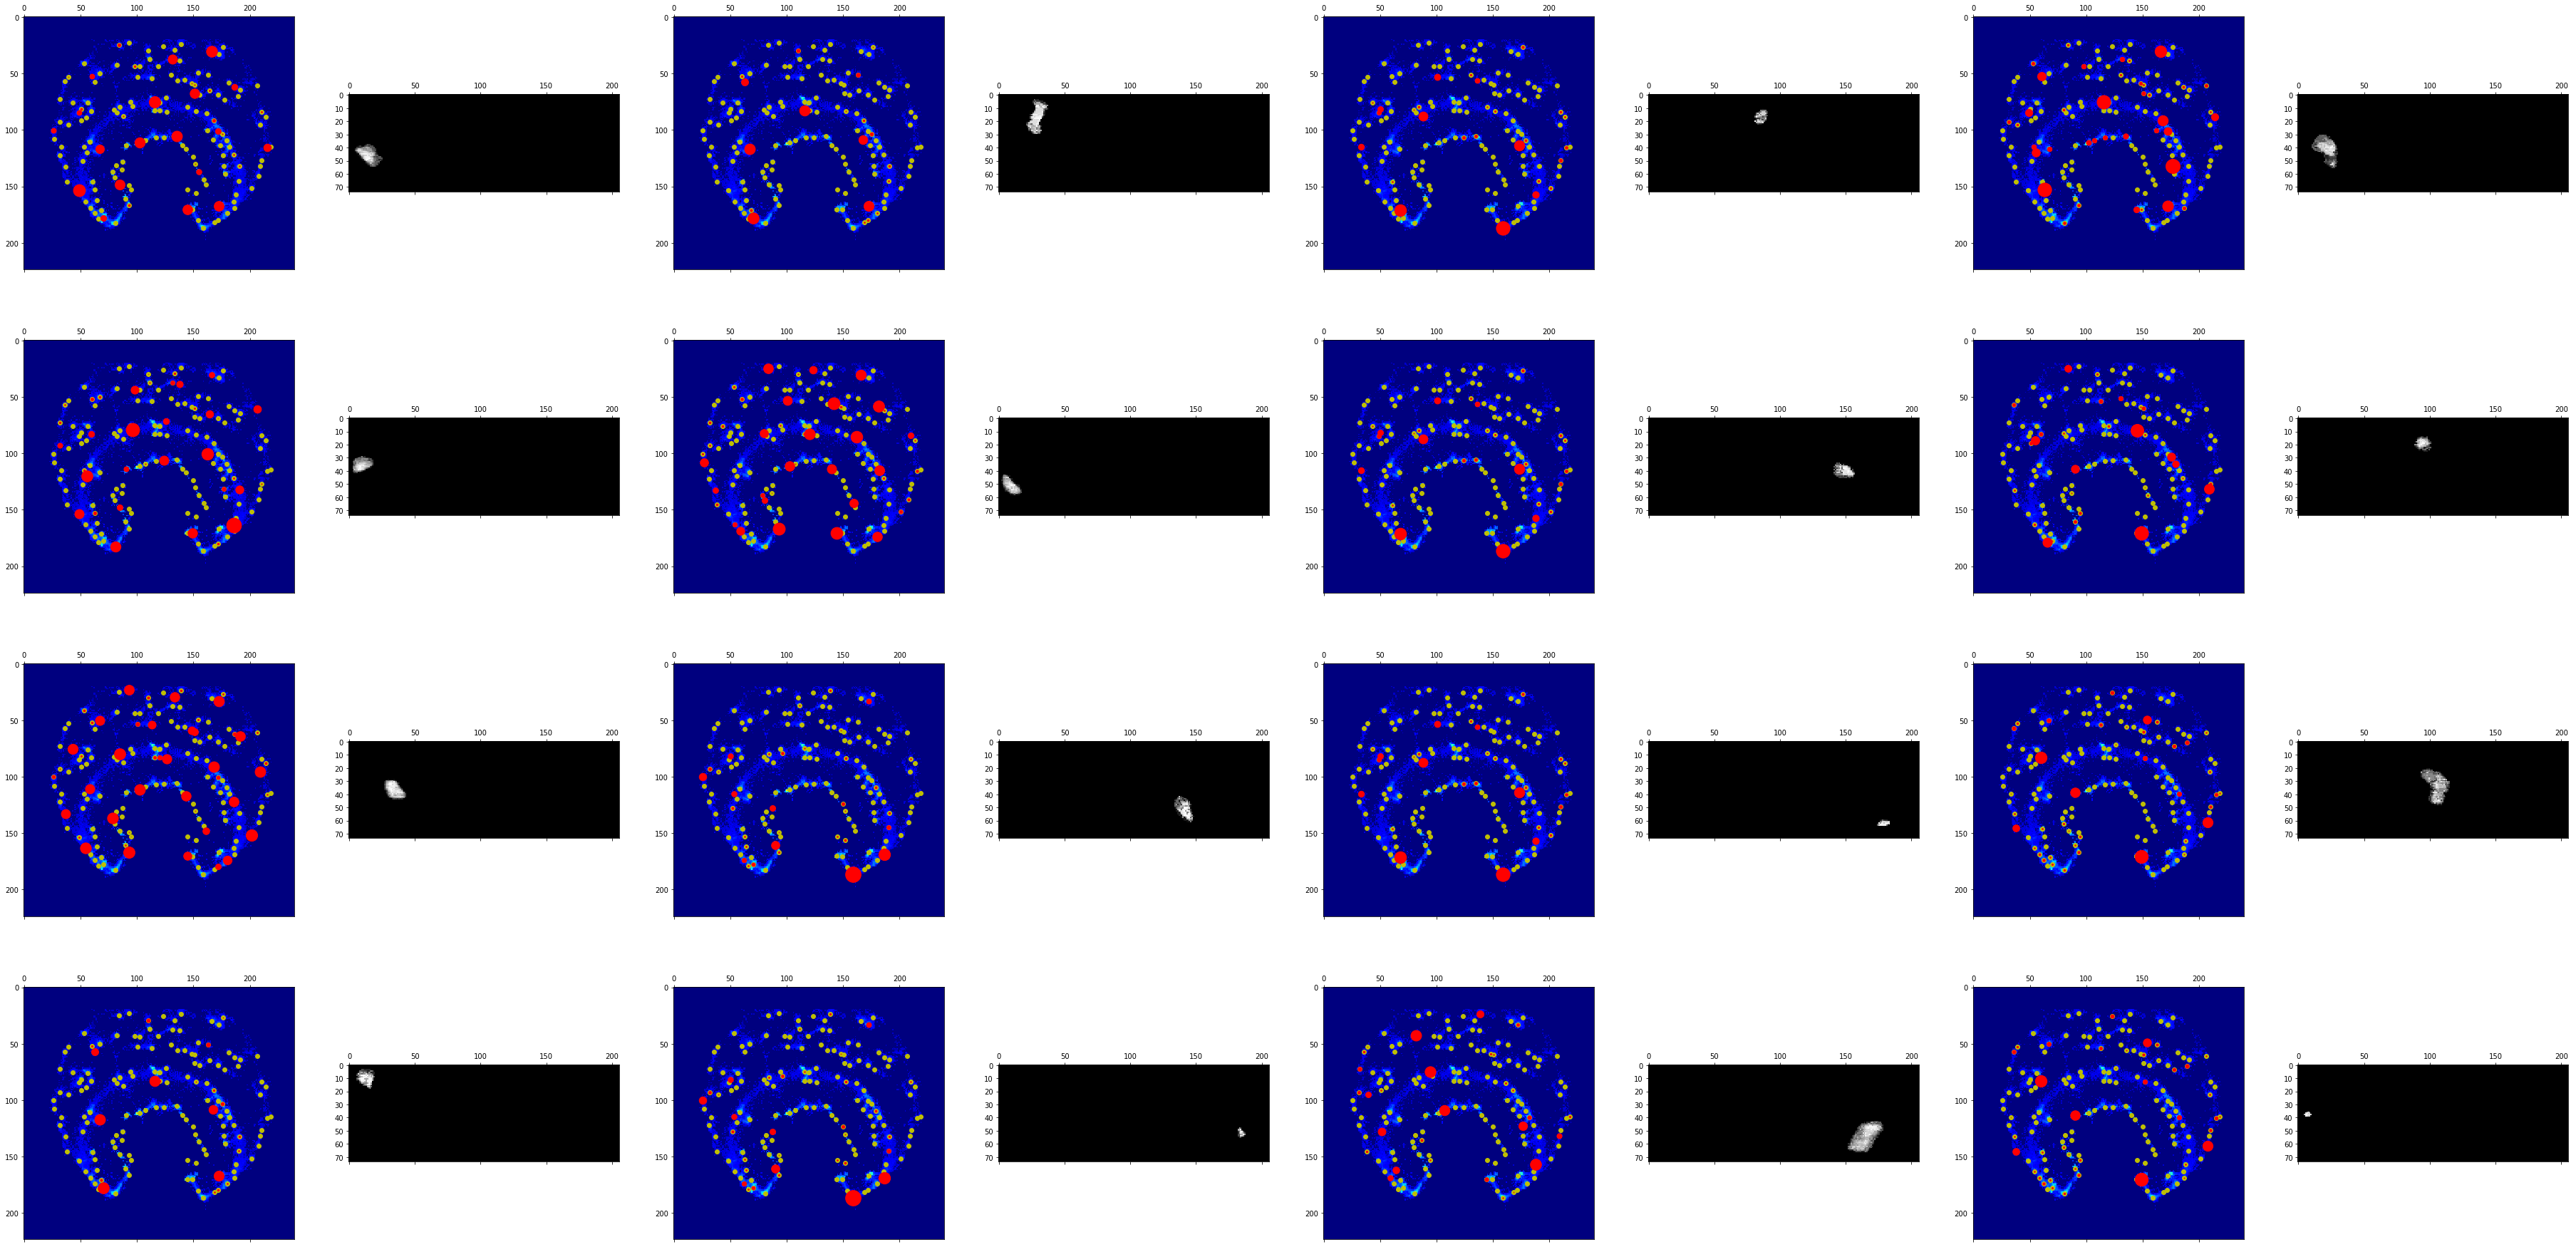

In [302]:
n = 1    # Plot classes in the range [16*n, 16*(n+1)]
sizescale=200

fig,axs = plt.subplots(4,8,figsize=(16*4,8*4))

for index in range(N_c):
    if (index >= 16*n) and (index < 16*(n+1)):
        ax1 = axs[index%4,2*((index-16*n)//4)]
        ax2 = axs[index%4,2*((index-16*n)//4)+1]
        
        BP_vals = W_split[:,index]
        R_vals = H_split[index,:]
        class_map = R_vals.reshape((R_Nx,R_Ny))

        ax1.matshow(deconvolution**power,cmap='jet')
        ax1.scatter(maxima_y,maxima_x,color='y')
        for i in range(N):
            ax1.scatter(maxima_y[i],maxima_x[i],color='r',s=sizescale*BP_vals[i])
        ax1.grid(False)
        ax2.matshow(class_map)
        ax2.grid(False)

plt.show()

/home/ben/Software/anaconda3/lib/python3.7/site-packages/matplotlib/image.py:405: UserWarning: Warning: converting a masked element to nan.
  dv = (np.float64(self.norm.vmax) -
/home/ben/Software/anaconda3/lib/python3.7/site-packages/matplotlib/image.py:406: UserWarning: Warning: converting a masked element to nan.
  np.float64(self.norm.vmin))
/home/ben/Software/anaconda3/lib/python3.7/site-packages/matplotlib/image.py:413: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/ben/Software/anaconda3/lib/python3.7/site-packages/matplotlib/image.py:418: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/ben/Software/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:916: UserWarning: Warning: converting a masked element to nan.
  dtype = np.min_scalar_type(value)
/home/ben/Software/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:715: UserWarning: Warning: converting a masked element to nan.
 

/home/ben/Software/anaconda3/lib/python3.7/site-packages/matplotlib/image.py:405: UserWarning: Warning: converting a masked element to nan.
  dv = (np.float64(self.norm.vmax) -
/home/ben/Software/anaconda3/lib/python3.7/site-packages/matplotlib/image.py:406: UserWarning: Warning: converting a masked element to nan.
  np.float64(self.norm.vmin))
/home/ben/Software/anaconda3/lib/python3.7/site-packages/matplotlib/image.py:413: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/ben/Software/anaconda3/lib/python3.7/site-packages/matplotlib/image.py:418: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/ben/Software/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:916: UserWarning: Warning: converting a masked element to nan.
  dtype = np.min_scalar_type(value)
/home/ben/Software/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:715: UserWarning: Warning: converting a masked element to nan.
 

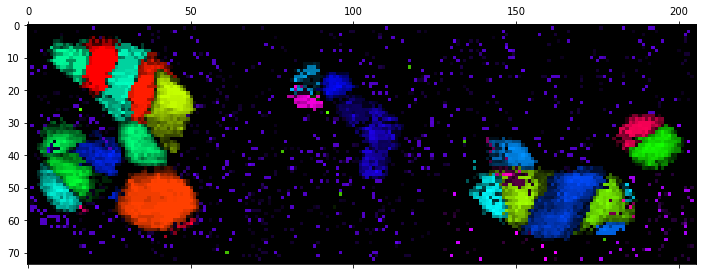

In [303]:
# Plot overlay

thresh = 0.3
cmap_base = get_cmap('hsv')

fig,ax = plt.subplots(figsize=(12,12))
ax.matshow(np.zeros((R_Nx,R_Ny)))

for index in range(N_c):
    R_vals = H_split[index,:]
    class_map = R_vals.reshape((R_Nx,R_Ny))
    ma = np.ma.array(class_map, mask = class_map<thresh)

    #colors = [(0,0,0,1),cmap_base(index/len(BP_sets))]
    c1 = cmap_base(index/N_c)
    c0 = (c1[0]/10.,c1[1]/10.,c1[2]/10.,1)
    colors = [c0,c1]
    cm = LinearSegmentedColormap.from_list('cmap', colors, N=100)
    ax.matshow(ma,cmap=cm)

plt.show()

In [ ]:
W = W_split
H = H_split

### Merge classes

### Combine classes

We need a rule for combining classes.  What shall we do?

Questions to answer...

- When do we combine classes?  This must include considerations of real space and diffraction space. Colin calculates correlegrams in both.  In real space, we can do a cross correlation, and look about 0.  In reciprocal space, we need to look at the overlap of Bragg peaks.  Do we want combine when one BP set is a subset of the other?  What do we do in cases with a large intersection, but elements of each outside the other?


### Split classes

We need a rule for splitting classes.  What shall we do?

In general, distinct real space regions seems reasonable to split; still, there is the question of regions with speckly noise giving rise to many small sets of islanded pixels - here it might be better to call this one class.  A Kernel Density Estimation sort of approach might help here.  This issue aside, how do we determine that we have distinct regions?  Connected component labelling seems a reasonable choice: https://en.wikipedia.org/wiki/Connected-component_labeling.  There is an skimage implementation: skimage.measure.label.  See https://scipy-lectures.org/packages/scikit-image/auto_examples/plot_labels.html for an example.  So, an approach to consider would be: start with the real space mask of a class.  Convolve with a kernel.  Threshold.  Perform connected component labelling.

Threshholding here may require some amount of caution, because if, say, one scan region contains two overlapping lattices, then the values of the X matrix will come from both of these two classes, thus each will contain only a fraction of the intensity of the class.  This suggests that a threshold should not necessarily be with respect to 1, but instead, with respect to something else - say, the maximum value in the real space class mask.

### Remove classes

When should a class simply be removed?

Perhaps: if its coefficients are all quite small?

### New classes

When do we make new classes?

Perhaps more importantly, how do we make new classes?

In [8]:
class ClassLabel(object):
    """
    The ClassLabel object contains data pertaining to a single classified region of real space.
    It is a python class used to classify space into k classes; a class class, if you will. So classy!
    Isn't overloaded language fun?
    
    This labels scan positions.  That is, this object specifies some sub-region of a 2D array (as a boolean array,
    self.mask) whose associated diffraction patterns are understood to be the constituents of this class.  Physically,
    each class is understood to correspond to a set of Bragg peaks; the relationship between these peaks in Q-space,
    and the relationship between these peaks and the diffraction patterns themselves, is left formally unspecified.
    
    Let there be a total of N Bragg peaks which have been detected in all DPs.  The class then contains the attributes
    y and w, which are length N vectors specifying the relationships of the Bragg peaks to the class: y is Boolean,
    with y[i] indicating if the i'th Bragg peak is considered to be associated with this class; w is a real number
    in [0,1], with w[i] indicated the strength of the association of the i'th Bragg peak with the class.
    
    For some diffraction pattern, let x be a length N Boolean vector, with x[i] indicating if the i'th Bragg peaks is
    contained in the DP.  We deem the DP to be more likely to be a member of the class if it minimizes the cost function
    
        $   c = - \sum_i(x_i y_i w_i) + V\sum_i(x_i \logical_xor y_i)   $ 
    
    where V idicates how strongly we penalize the DP and the class having differing Bragg peaks.
    
    Summarizing the relevant quantities:
         x              (length N array of bools) self.x[i] is True if $i\in s$, i.e. if the i'th BP is in this DP
         self.y         (length N array of bools) self.y[i] is True if the i'th DP is associated with this class
         self.w         (length N array of floats) self.w[i] quantifies the strength with which we associate the
                                                   i'th DP with the class.
         self.V         (int) how strongly we penalize x and y having differing Bragg peaks
         
    The quantities are determined as follows:
        x               Initially, Bragg peaks are found using cross-correlation with a template vaccuum probe kernel.
                        Indexes are assigned to the Bragg peaks according to their regions in a Voronoi tesselation
                        seeded with the maxima of the average deconvolution.  The boolean vector x for some DP is then
                        constucting by setting x[i]=True whenever one of the Bragg peaks found in this DP was found to
                        have index i.
        self.y          Set using a simple threshold with respect to self.w.  self.y[i] is True whenever
                        self.w[i] > self.thresh.
        self.w          The fraction of the class DPs containing each Bragg peak.
        self.V          User specified.
        self.thresh     User specified.
         
    A ClassLabel must be initialized with some starting scan positions, by specifying a 2D Boolean realslice-shaped
    mask.  This is used to construct and initialize self.y, and self.w.
    """    
    def __init__(self, index, mask, V, thresh, 
                        braggpeak_labels, N, R_Nx, R_Ny):
        """
        Initialize a ClassLabel object. 
        
        Accepts:
            index               (int) the class index
            mask                (2D array of bools) initial scan positions to include
            V                   (float) scales penalty for nonoverlapped Bragg peaks
            thresh              (float) min value of self.w[i] at which self.y[i] is set to True
            braggpeak_labels    (list of lists of sets) the indices of the Bragg peaks found at each scan position
            N                   (int) the total number of indexed BPs
            R_Nx                (int) x scan shape
            R_Ny                (int) y scan shape
        """
        # Class parameters
        self.index = index
        self.mask = np.zeros((R_Nx,R_Ny),dtype=bool)
        self.V = V
        self.thresh = thresh
        self.braggpeak_labels = braggpeak_labels
        self.N = N
        self.y = np.zeros(self.N,dtype=bool)
        self.w = np.zeros(self.N,dtype=float)
        
        # Machinery
        self.counts_per_BP = np.zeros(self.N,dtype=int)
        self.N_DP = 0
        self.cost = 0
        
        # Add initial points
        rx,ry = np.nonzero(mask)
        self.add_data_by_scan_position(rx,ry)
        return

    def add_data_by_scan_position(self,rx,ry):
        if isinstance(rx,(int,np.integer)) and isinstance(ry,(int,np.integer)):
            if not self.mask[rx,ry]:
                self.mask[rx,ry] = True
                self.N_DP += 1
                s = self.braggpeak_labels[rx][ry]
                for i in s:
                    self.counts_per_BP[i] += 1
        else:
            assert len(rx)==len(ry)
            for j in range(len(rx)):
                if not self.mask[rx[j],ry[j]]:
                    self.mask[rx[j],ry[j]] = True
                    self.N_DP += 1
                    s = braggpeak_sets[rx[j]][ry[j]]
                    for i in s:
                        self.counts_per_BP[i] += 1
        self.get_w()
        self.get_y()
        self.get_cost()
        
    def remove_data_by_scan_position(self,rx,ry):
        if isinstance(rx,(int,np.integer)) and isinstance(ry,(int,np.integer)):
            if self.mask[rx,ry]:
                self.mask[rx,ry] = False
                self.N_DP -= 1
                s = braggpeak_sets[rx][ry]
                for i in s:
                    self.counts_per_BP[i] -= 1
        else:
            assert len(rx)==len(ry)
            for j in range(len(rx)):
                if self.mask[rx[j],ry[j]]:
                    self.mask[rx[j],ry[j]] = False
                    self.N_DP -= 1
                    s = braggpeak_sets[rx[j]][ry[j]]
                    for i in s:
                        self.counts_per_BP[i] -= 1
        self.get_w()
        self.get_y()
        self.get_cost()
        
    def get_w(self):
        self.w = self.counts_per_BP.astype(float)/self.N_DP
        
    def get_y(self):
        self.y = self.w > self.thresh
        
    def get_cost_of_set(self,s):
        """
        Computes the cost of adding a DP containing set s of Bragg peak indices to the class, using the current state
        of self.y and self.w.
        """
        if self.N_DP==0:
            return 0
        x = self.s_to_array(s)
        return -np.sum(x*self.y*self.w - self.V*np.logical_xor(x,self.y))

    def get_cost(self):
        """
        Get the total cost of the ClassLabel instance.
        """
        cost = 0
        rx,ry = np.nonzero(self.mask)
        for i in range(len(rx)):
            s = braggpeak_sets[rx[i]][ry[i]]
            cost += self.get_cost_of_set(s)
        self.cost = cost
        return self.cost
    
    def s_to_array(self,s):
        """
        Converts a set of indices s to a length N Boolean array x which is True at x[i] if i is in s.
        """
        x = np.zeros(self.N,dtype=bool)
        for i in s:
            x[i] = True
        return x